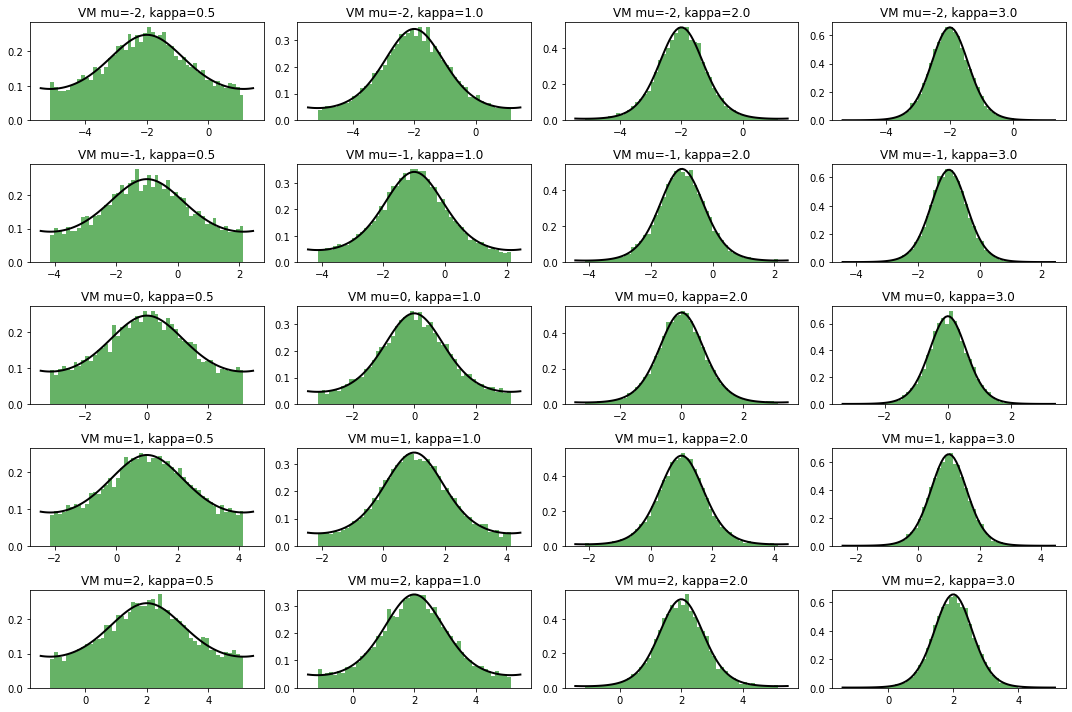

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Example inputs
mus = np.array([-2, -1, 0, 1, 2])  # Example means (length n)
sigmas = np.array([.5, 1, 2, 3])  # Example standard deviations (length m)
num_samples = 10000  # Number of samples to generate for each distribution

# Generate samples using broadcasting with 2D arrays
# Here, mus[:, np.newaxis] reshapes mus to (n, 1) and sigmas[np.newaxis, :] reshapes sigmas to (1, m)
samples = vonmises.rvs(loc=mus[:, np.newaxis], kappa=sigmas[np.newaxis, :], 
                           size=(num_samples, len(mus), len(sigmas)))

# Plotting the results
fig, axes = plt.subplots(len(mus), len(sigmas), figsize=(15, 10))

for i in range(len(mus)):
    for j in range(len(sigmas)):
        ax = axes[i, j]
        
        # Plot histogram of the samples
        ax.hist(samples[:, i, j], bins=50, density=True, alpha=0.6, color='g')
        
        # Plot the theoretical normal distribution curve
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = vonmises.pdf(x,loc= mus[i], kappa=sigmas[j])
        ax.plot(x, p, 'k', linewidth=2)
        
        title = f"VM mu={mus[i]}, kappa={sigmas[j]}"
        ax.set_title(title)

plt.tight_layout()
plt.show()

# Causal Inference in Internal space with Angle space responses

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pickle
import uniformised_space_utils as usu
from scipy.stats import vonmises, circmean
import matplotlib.pyplot as plt
from custom_causal_inference import CustomCausalInference
from repulsion_hypothesis import repulsion_value

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [8]:
num_sim = 1000
D = 250  # grid dimension 
angle_gam_data_path = 'D:/AK_Q1_2024/Gatsby/data/base_bayesian_contour_1_circular_gam/base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='D:/AK_Q1_2024/Gatsby/uniform_model_base_inv_kappa_free.pkl'
# Load the GAM.
with open(angle_gam_data_path, 'rb') as file:
    gam_data = pickle.load(file)
# Load the uniformising function data.
with open(unif_fn_data_path, 'rb') as file:
    unif_fn_data = pickle.load(file)
# Initialise uniformising function map.
unif_map = usu.UnifMap(data=unif_fn_data)
unif_map.get_cdf_and_inverse_cdf()
grid = np.linspace(-np.pi, np.pi, num=D)

<Figure size 576x432 with 0 Axes>

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

In [9]:
def get_s_n_and_t(grid, gam_data, step=1, t_index=2):
    indices = np.arange(len(grid), step=step)
    t, s_n = np.meshgrid(grid[indices], grid[indices], indexing='ij')
    r_n = gam_data['full_pdf_mat'][indices, :, t_index]
    r_n = r_n[:, indices]
    return s_n, t, r_n

In [15]:
def heatmap_f_s_n_t(f_s_n_t, s_n, t, f_name):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(s_n[0], t[:,0], f_s_n_t, shading='auto', cmap='RdBu_r')
    plt.colorbar(label=f_name)
    plt.xlabel('s_n')
    plt.ylabel('t')
    plt.title(f'Heatmap of {f_name} with s_n and t')
    plt.show()

Get the s_n, t, r_n(s_n, t) values of interest

In [29]:
s_n, t, r_n = get_s_n_and_t(grid, gam_data)
s_n.shape, t.shape, r_n.shape

((250, 250), (250, 250), (250, 250))

Further filer the values of s_n, t considered (and r_n implicitly) for faster simulations

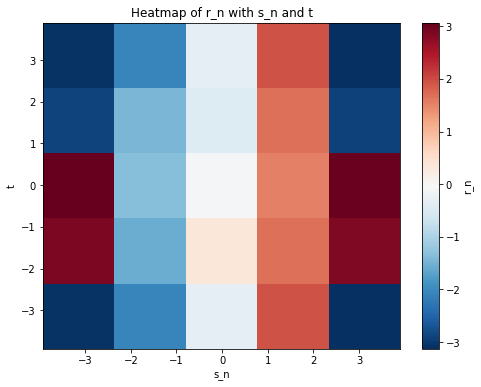

In [30]:
num_means = 4
step=len(s_n)//num_means
indices = np.arange(0, s_n.shape[0], step=step)
mu_x_dim = len(indices)
s_n = s_n[indices][:, indices]
t = t[indices][:, indices]
r_n = r_n[indices][:, indices]
heatmap_f_s_n_t(f_s_n_t=r_n, s_n=s_n, t=t, f_name='r_n')

In [17]:
s_n.shape, t.shape

((10, 10), (10, 10))

## Causal inference

In [31]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
kappa1 = np.array([50, 70, 100])
kappa2 = np.array([40, 60, 90])

In [32]:
t_samples = vonmises(loc=ut[:, np.newaxis], kappa=kappa1[np.newaxis, :]).rvs(size=(num_sim, ut.shape[0], kappa1.shape[0]))
s_n_samples = vonmises(loc=us_n[:, np.newaxis], kappa=kappa2[np.newaxis, :]).rvs(size=(num_sim, us_n.shape[0], kappa2.shape[0]))
t_samples.shape, s_n_samples.shape

((1000, 25, 3), (1000, 25, 3))

In [33]:
decision_rules = ['mean']
response_dict = {}
p_commons = [0., 0.2, 0.5, 0.7, 1]
for decision_rule in decision_rules:
        model = CustomCausalInference(decision_rule=decision_rule)
        response_dict[decision_rule] = {'responses': [], 
                                        'mean_sn_estimate': [],
                                        'mean_t_estimate': [],
                                        'posterior_p_common': [],
                                        }
        for pc_idx, p_common in enumerate(p_commons):
            # Add "optimal" estimates for s_n and t for every pair of samples assuming P(C=1)=p_common.
            response_dict[decision_rule]['responses'].append(model.bayesian_causal_inference(x_v=t_samples, 
                                                                                x_a=s_n_samples, 
                                                                                sigma_v=kappa1, 
                                                                                sigma_a=kappa2,
                                                                                mu_p=None, 
                                                                                sigma_p=None,
                                                                                pi_c=p_common))
            response_dict[decision_rule]['posterior_p_common'].append(model.posterior_prob_common_cause(x_v=t_samples, 
                                                                                x_a=s_n_samples, 
                                                                                sigma_v=kappa1, 
                                                                                sigma_a=kappa2,
                                                                                mu_p=None, 
                                                                                sigma_p=None,
                                                                                pi_c=p_common))
            # Find circular mean across "optimal" estimates for samples.
            mean_t_est = circmean(unif_map.unif_space_to_angle_space(response_dict[decision_rule]['responses'][-1][0]), 
                                  low=-np.pi, high=np.pi, axis=0)
            mean_sn_est = circmean(unif_map.unif_space_to_angle_space(response_dict[decision_rule]['responses'][-1][1]),
                                  low=-np.pi, high=np.pi, axis=0)
            response_dict[decision_rule]['mean_sn_estimate'].append(mean_sn_est)
            response_dict[decision_rule]['mean_t_estimate'].append(mean_t_est)

Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=1) using analytic solution on sampled x_V, x_A
Computing p(x_V, x_A| C=2) using analytic solution on sampled x_V, x_A
Comput

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

In [45]:
def plot_estimate(us_n, ut, r_n, mu_x_dim, estimate, est_label, plot_heatmap):
    plt.scatter(us_n, ut, label='u_t', alpha=.5)
    plt.scatter(us_n, r_n, label='r_n', alpha=.5)
    if estimate.ndim > 1:
        for i in range(estimate.shape[1]):
            plt.scatter(us_n, estimate[:,i], label=f'{est_label}_i', alpha=.5)
    else:
        plt.scatter(us_n, estimate, label=est_label, alpha=.5)
    plt.title(f'Values for {est_label}')
    plt.xlabel('us_n')
    plt.legend()
    plt.show()
    plt.clf()
    if plot_heatmap:
        uts_unq = ut.reshape(mu_x_dim,mu_x_dim)[:,0]
        if estimate.ndim > 1:
            for i in range(estimate.shape[1]):
                plt.pcolormesh(us_n[:mu_x_dim], uts_unq, 
                                estimate[:,i].reshape(mu_x_dim,mu_x_dim), 
                                shading='auto', cmap='RdBu_r')
                plt.colorbar(label=est_label)
                plt.title(f'Heatmap for {est_label}_i')
                plt.xlabel('us_n')
                plt.ylabel('ut')
                plt.show()
                plt.clf()

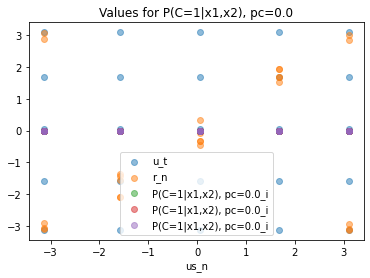

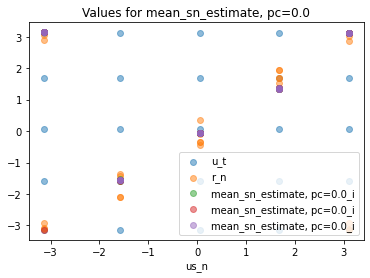

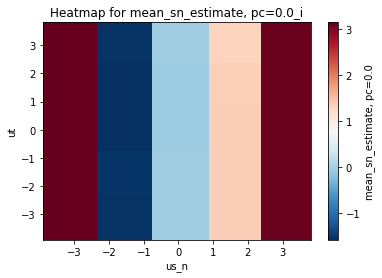

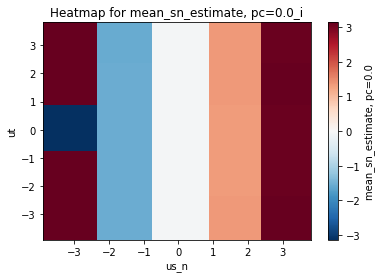

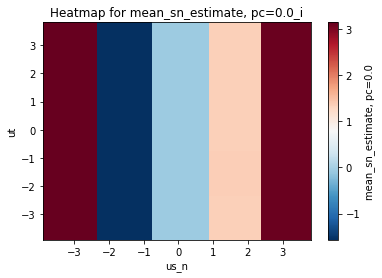

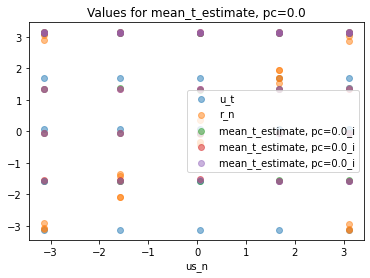

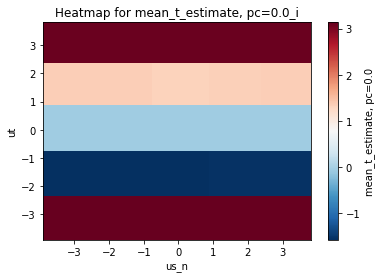

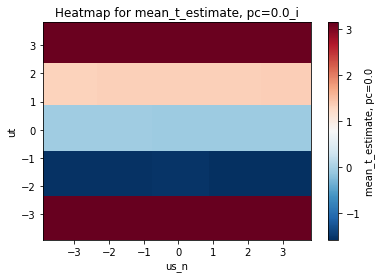

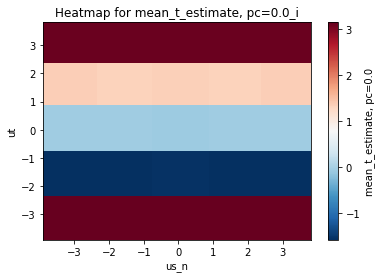

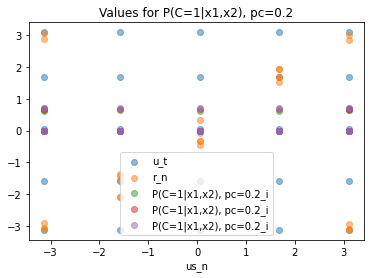

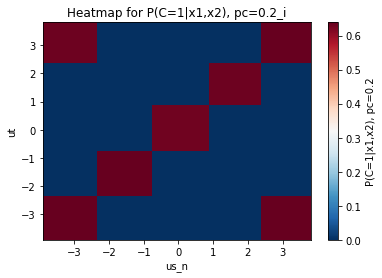

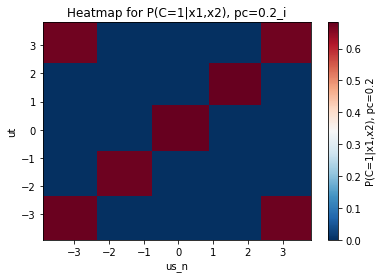

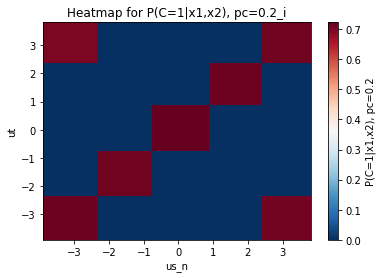

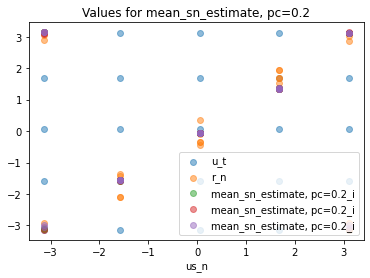

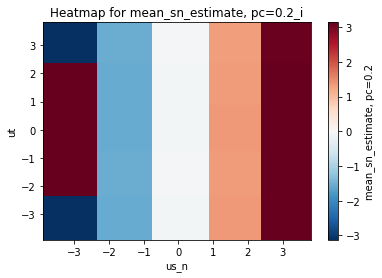

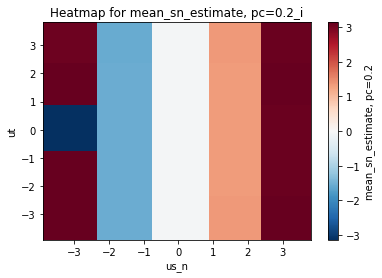

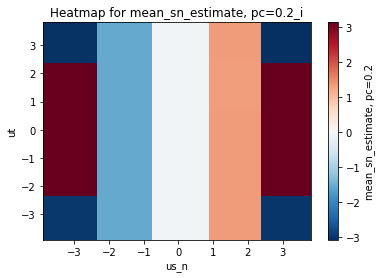

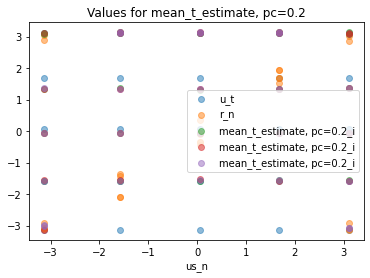

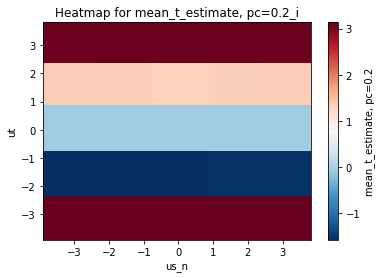

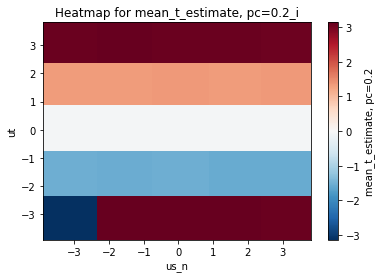

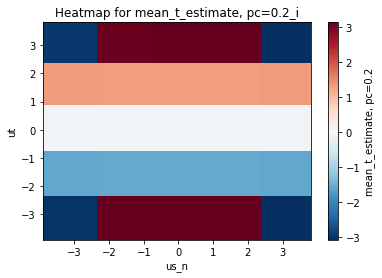

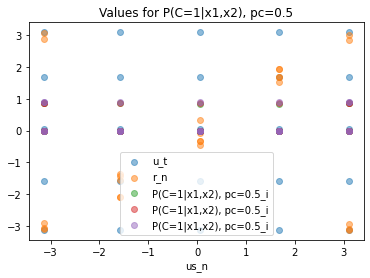

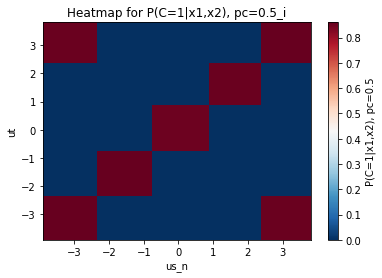

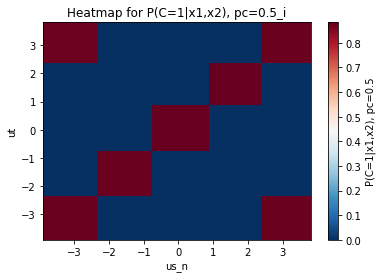

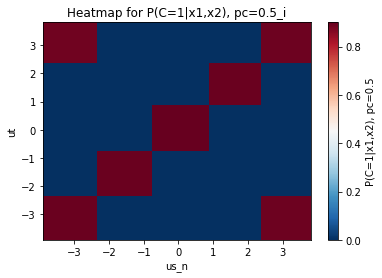

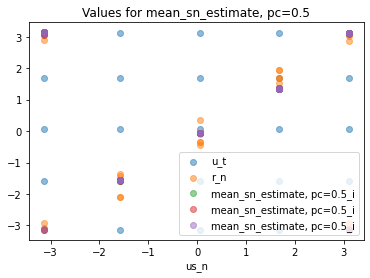

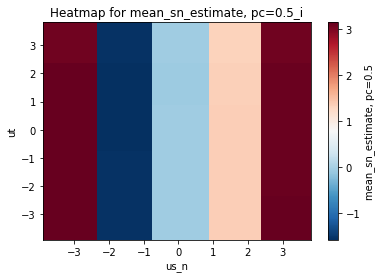

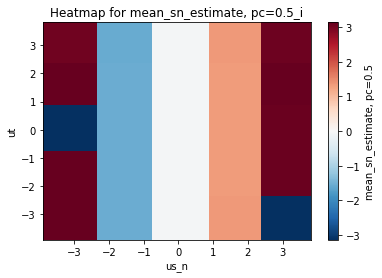

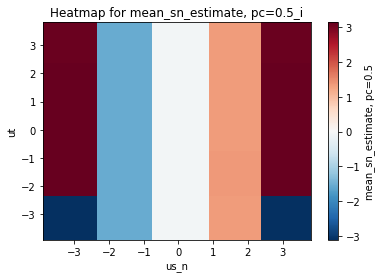

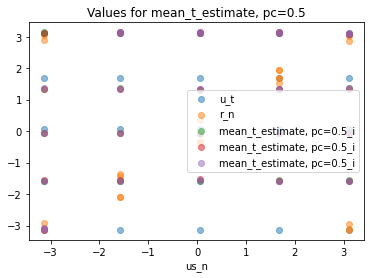

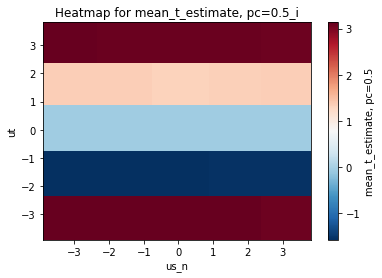

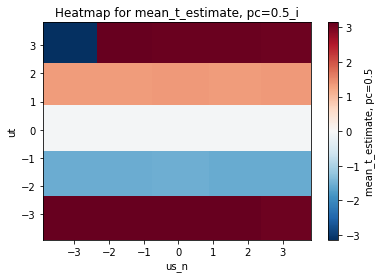

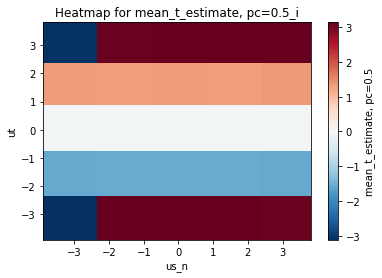

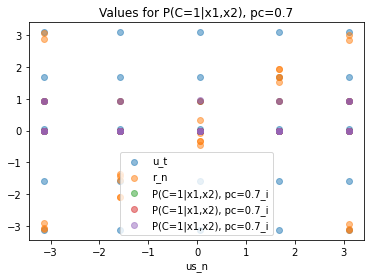

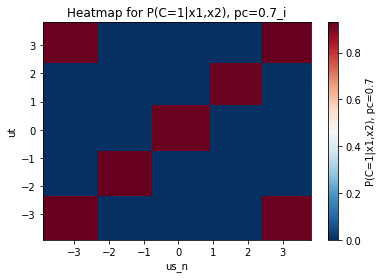

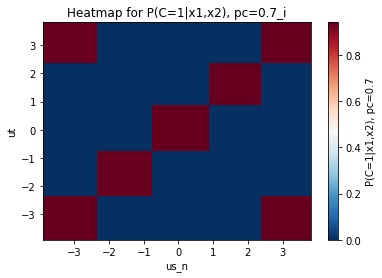

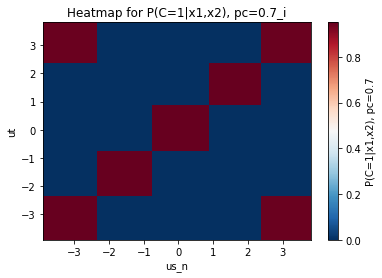

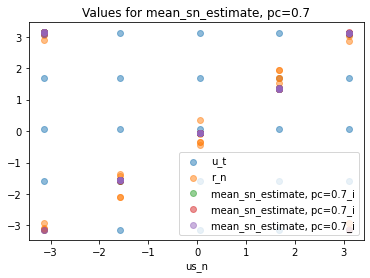

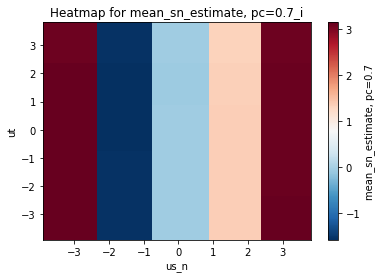

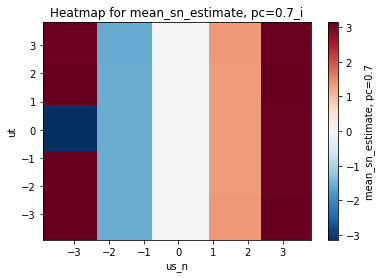

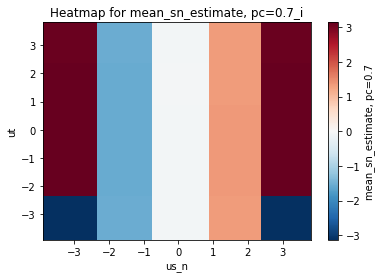

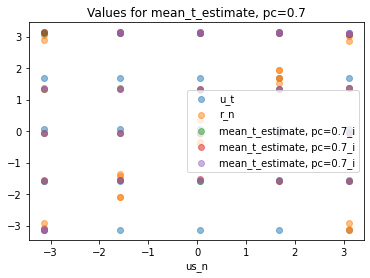

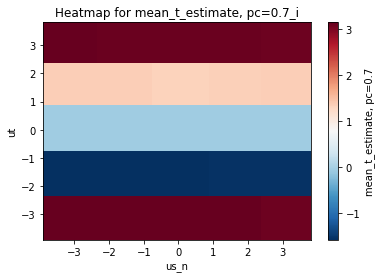

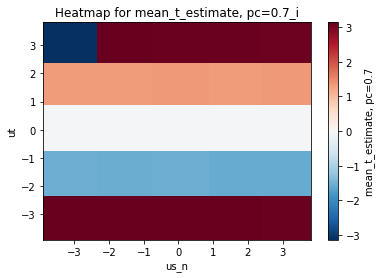

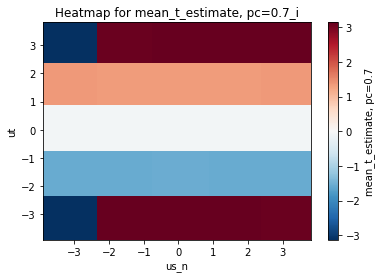

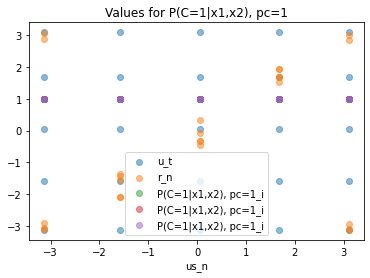

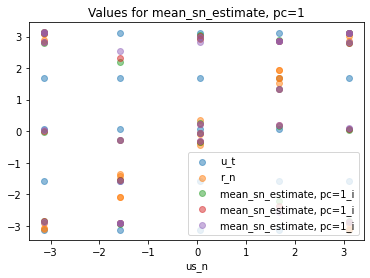

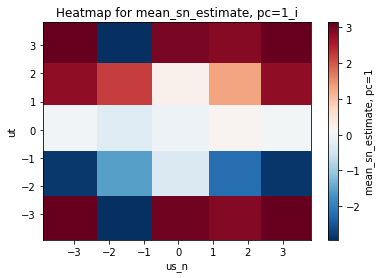

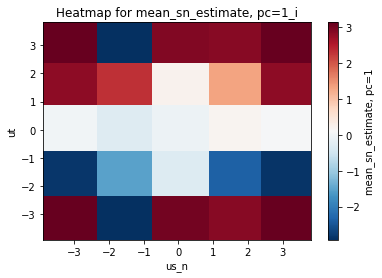

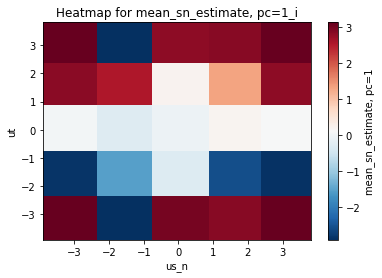

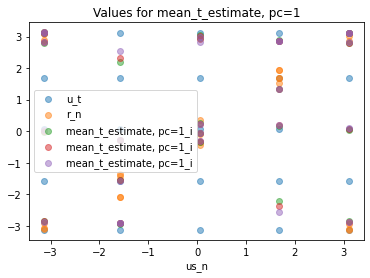

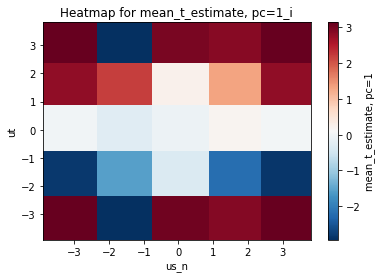

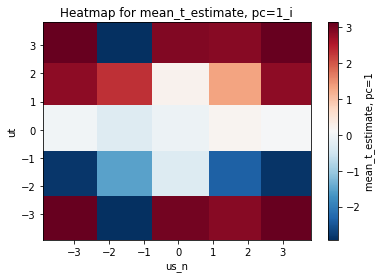

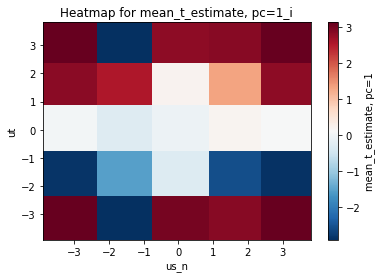

<Figure size 432x288 with 0 Axes>

In [46]:
assert (len(us_n) == mu_x_dim**2)
for decision_rule in decision_rules:
    for i, p_c in enumerate(p_commons):
       plot_heatmap = (p_c < 1) and (p_c > 0)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['posterior_p_common'][i].mean(axis=0),
                     est_label=f'P(C=1|x1,x2), pc={p_c}', 
                     plot_heatmap=plot_heatmap)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['mean_sn_estimate'][i],
                     est_label=f'mean_sn_estimate, pc={p_c}', 
                     plot_heatmap=True)
       plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=mu_x_dim, 
                     estimate=response_dict[decision_rule]['mean_t_estimate'][i],
                     est_label=f'mean_t_estimate, pc={p_c}', 
                     plot_heatmap=True)